# Ensembles con Training Separado

En esta notebook, veremos de hacer un ensemble neuronal de las técnicas vistas hasta el momento (y quizás alguna más).

A diferencia de los modelos anteriores, acá los vamos a entrenar por separado y luego ensamblar

Vamos a usar

- Modelo char
- Modelo BoW
- Modelo ElMO
- Quizás modelo de Word Embeddings


In [1]:
import pandas as pd
import csv

df_dev = pd.read_table("../../../data/es/dev_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_train = pd.read_table("../../../data/es/train_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)

text_train, y_train = df_train["text"], df_train["HS"]
text_dev, y_dev = df_dev["text"], df_dev["HS"]

print("Instancias de entrenamiento: {}".format(len(df_train)))
print("Instancias de desarrollo: {}".format(len(df_dev)))


Instancias de entrenamiento: 4500
Instancias de desarrollo: 500


In [2]:
import os
import glob
from hate.utils import load_embedding

path_to_embeddings = os.path.expanduser("~/WordVectors")

print("Embeddings disponibles")
print(glob.glob(path_to_embeddings+"/*.vec"))

word_to_vec = load_embedding(os.path.join(path_to_embeddings, "UBA_w5_300.vec"))

Using TensorFlow backend.


Embeddings disponibles
['/home/jmperez/WordVectors/UBA_w5_200.vec', '/home/jmperez/WordVectors/wiki.es.vec', '/home/jmperez/WordVectors/UBA_w5_300.vec']
Problema con la sig línea:
['.', '.', '-0.22232', '0.0052569', '0.47066', '0.13836', '0.15991', '0.19504', '0.00067885', '0.020299']
Problema con la sig línea:
['.', '...', '-0.11666', '-0.083768', '0.028919', '0.29973', '0.21017', '0.27808', '0.063251', '0.090223']
Problema con la sig línea:
['.', '..', '-0.43752', '-0.0016885', '0.1533', '0.28071', '0.18051', '0.28698', '0.11806', '0.044891']


Hagamos tokenize sobre el texto

In [3]:
%matplotlib inline
from nltk.tokenize import TweetTokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
import unidecode


stemmer = SnowballStemmer('spanish')

def tokenize(tweet, stem=False, deaccent=True, alpha_only=False, **kwargs):
    tokenizer = TweetTokenizer(**kwargs)
    tokens = tokenizer.tokenize(tweet)
    
    ret = []
    
    def fstem(x):
        if stem:
            return stemmer.stem(x)
        else:
            return x
        
    for token in tokens:
        tok = None
        if token[0] == "#":            
            tok = fstem(token[1:])
        elif token[0] == "@":
            tok = "@user"
        elif "http" in token:
            continue
        else:
            tok = fstem(token)
        
        if deaccent and tok.isalpha():
            tok = unidecode.unidecode(tok)
        if alpha_only and not tok.isalpha():
            continue
        
        ret.append(tok)
    return ret



## Embeddings Model

In [4]:
tokenize_args = {
    "preserve_case": False, 
    "deaccent": False,
    "reduce_len": True, 
    "strip_handles": False,
    "stem": False,
    "alpha_only": True
}

text_train = [" ".join(tokenize(t, **tokenize_args)) for t in df_train["text"].values]
text_dev = [" ".join(tokenize(t, **tokenize_args)) for t in df_dev["text"].values]


In [5]:
text_train[-1]

'no hay nada más lento que un caracol cállate hijo de puta eso lo dices porque no tienes blackberry'

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

emb_num_words = 12500

tokenizer = Tokenizer(num_words=emb_num_words)
tokenizer.fit_on_texts(text_train)

emb_train = tokenizer.texts_to_sequences(text_train)
emb_dev = tokenizer.texts_to_sequences(text_dev)


In [7]:
print("Vocabulario: {} palabras".format(len(tokenizer.word_index)))

Vocabulario: 14008 palabras


(array([525., 981., 923., 771., 415., 331., 286., 181.,  73.,  14.]),
 array([ 1. ,  6.8, 12.6, 18.4, 24.2, 30. , 35.8, 41.6, 47.4, 53.2, 59. ]),
 <a list of 10 Patch objects>)

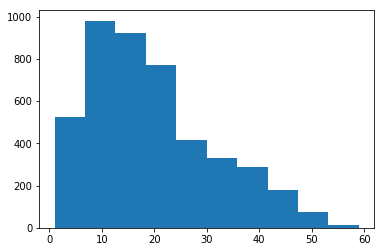

In [8]:
plt.hist([len(t) for t in emb_train])

In [9]:

emb_max_length = 50

X_emb_train = pad_sequences(emb_train, emb_max_length)
X_emb_dev = pad_sequences(emb_dev, emb_max_length)

In [10]:
# create a weight matrix for words in training docs
import numpy as np

embedding_size = word_to_vec["hola"].shape[0]
embedding_matrix = np.zeros((emb_num_words, embedding_size))

for word, i in tokenizer.word_index.items():
    embedding_vector = word_to_vec.get(word)
    if embedding_vector is not None and i < emb_num_words:
        embedding_matrix[i] = embedding_vector

## Bow Model

In [11]:

tokenize_args = {
    "preserve_case": False, 
    "deaccent": False,
    "reduce_len": True, 
    "strip_handles": False,
    "stem": True,
    "alpha_only": True
}
vect = CountVectorizer(tokenizer=lambda t: tokenize(t, **tokenize_args), 
                       max_df=0.90, min_df=0.001, ngram_range=(1, 2), binary=True)

vect.fit(df_train["text"])

X_bow_train = vect.transform(df_train["text"])
X_bow_dev = vect.transform(df_dev["text"])

X_bow_train.shape, X_bow_dev.shape

((4500, 3662), (500, 3662))

## Char Input

In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

vocab_size = 200


tokenize_args = {
    "preserve_case": False, 
    "deaccent": True,
    "reduce_len": True, 
    "strip_handles": False,
    "stem": True,
    "alpha_only": False
}

text_train = [" ".join(tokenize(t, **tokenize_args)) for t in df_train["text"].values]
text_dev = [" ".join(tokenize(t, **tokenize_args)) for t in df_dev["text"].values]

char_tokenizer = Tokenizer(num_words=vocab_size, char_level=True, 
                           lower=tokenize_args["preserve_case"])
char_tokenizer.fit_on_texts(text_train)

X_char_train = char_tokenizer.texts_to_sequences(text_train)
X_char_dev = char_tokenizer.texts_to_sequences(text_dev)

(array([358., 909., 892., 801., 491., 274., 256., 264., 220.,  35.]),
 array([  5. ,  32.1,  59.2,  86.3, 113.4, 140.5, 167.6, 194.7, 221.8,
        248.9, 276. ]),
 <a list of 10 Patch objects>)

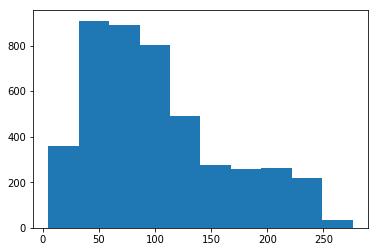

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist([len(seq) for seq in X_char_train])

Sanity check: veamos que si "destokenizo", me reconstruye algo razonable

In [14]:
print(char_tokenizer.sequences_to_texts(X_char_train[0:1]))
print(text_train[0])
print(char_tokenizer.sequences_to_texts(X_char_train[1:2]))
print(text_train[1])

["e a s y j e t   q u i e r   d u p l i c   e l   n u m e r   d e   m u j e r   p i l o t   '   v e r a s   t u   p a r   a p a r c   e l   a v i o n   . ."]
easyjet quier duplic el numer de mujer pilot ' veras tu par aparc el avion ..
['e l   g o b i e r n   d e b   c r e   u n   c o n t r o l   e s t r i c t   d e   i n m i g r   e n   l a s   z o n   f r o n t e r i z   c o n   c o l o m b i   p o r   q   d e s p u e s   d e l   2 0 - 8   q u e r r a n   v e n   e n   m a s']
el gobiern deb cre un control estrict de inmigr en las zon fronteriz con colombi por q despues del 20-8 querran ven en mas


In [15]:

max_charlen = 300

X_char_train = pad_sequences(X_char_train, maxlen=max_charlen)
X_char_dev = pad_sequences(X_char_dev, maxlen=max_charlen)

## Elmo Input

In [16]:
from keras.utils import to_categorical
import numpy as np

tokenize_args = {
    "preserve_case": False, 
    "deaccent": False,
    "reduce_len": True, 
    "strip_handles": False,
    "alpha_only": True,
}


tokens_train = [tokenize(tweet, **tokenize_args) for tweet in df_train["text"].values]
tokens_dev = [tokenize(tweet, **tokenize_args) for tweet in df_dev["text"].values]

tokens_train[0]

['easyjet',
 'quiere',
 'duplicar',
 'el',
 'número',
 'de',
 'mujeres',
 'piloto',
 'verás',
 'tú',
 'para',
 'aparcar',
 'el',
 'avión']

Ahora, calculemos los inputs de ElMO

(array([505., 959., 927., 772., 417., 336., 285., 200.,  82.,  17.]),
 array([ 1. ,  6.8, 12.6, 18.4, 24.2, 30. , 35.8, 41.6, 47.4, 53.2, 59. ]),
 <a list of 10 Patch objects>)

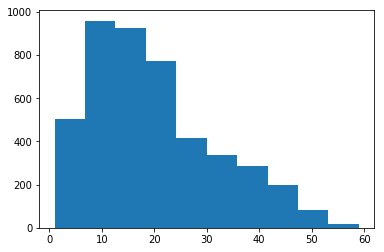

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist([len(t) for t in tokens_train])

Padeamos los vectores con espacios

In [18]:
elmo_max_length = 50

def pad_tokens(tokens, max_len):
    if len(tokens) >= max_len:
        return tokens[:max_len]
    else:
        tokens = tokens + [''] * (max_len - len(tokens))
    return tokens

padded_tokens_train = [pad_tokens(seq, elmo_max_length) for seq in tokens_train]
padded_tokens_dev = [pad_tokens(seq, elmo_max_length) for seq in tokens_dev]


In [19]:
%%capture
from elmoformanylangs import Embedder

e = Embedder("../../../models/elmo/es/")

In [20]:
import numpy as np

print(padded_tokens_train[0])

elmo_dim = 1024

elmo_train = np.array(e.sents2elmo(padded_tokens_train, -1))
elmo_dev = np.array(e.sents2elmo(padded_tokens_dev, -1))

['easyjet', 'quiere', 'duplicar', 'el', 'número', 'de', 'mujeres', 'piloto', 'verás', 'tú', 'para', 'aparcar', 'el', 'avión', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


(array([8.7600e+04, 5.0632e+04, 2.1550e+04, 3.0614e+04, 2.4553e+04,
        8.9620e+03, 1.0110e+03, 7.2000e+01, 4.0000e+00, 2.0000e+00]),
 array([13.044178, 16.201115, 19.35805 , 22.514986, 25.67192 , 28.828857,
        31.985794, 35.14273 , 38.299664, 41.4566  , 44.613537],
       dtype=float32),
 <a list of 10 Patch objects>)

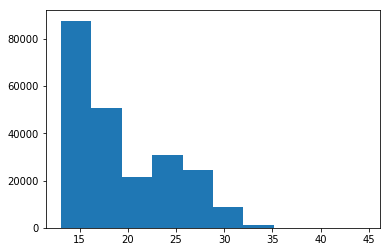

In [21]:
plt.hist([np.linalg.norm(t) for seq in elmo_train for t in seq ])

In [22]:

def pad_vectors(X, max_len, norm=False):
    pad_vector = np.zeros((1, elmo_dim))
    ret = []
    
    for seq in X:
        if norm:
            seq = seq / np.linalg.norm(seq, axis=1)[..., np.newaxis]
        if len(seq) > max_len:
            ret.append(seq[:max_len])
        else:
            padded = np.vstack([
                seq, 
                np.zeros((max_len - len(seq), elmo_dim))
            ])
            
            ret.append(padded)
        
    return ret


X_elmo_train = np.array(pad_vectors(elmo_train, elmo_max_length))
X_elmo_dev = np.array(pad_vectors(elmo_dev, elmo_max_length))

X_elmo_train.shape, X_elmo_dev.shape

((4500, 50, 1024), (500, 50, 1024))

(array([8.7600e+04, 5.0632e+04, 2.1550e+04, 3.0614e+04, 2.4553e+04,
        8.9620e+03, 1.0110e+03, 7.2000e+01, 4.0000e+00, 2.0000e+00]),
 array([13.04417761, 16.20111336, 19.35804911, 22.51498485, 25.6719206 ,
        28.82885635, 31.9857921 , 35.14272785, 38.2996636 , 41.45659935,
        44.61353509]),
 <a list of 10 Patch objects>)

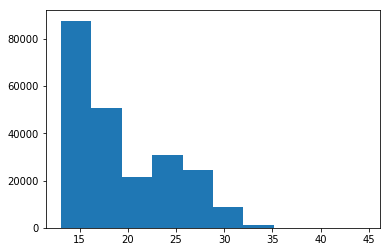

In [23]:
norms = [np.linalg.norm(t) for seq in X_elmo_train for t in seq ]

plt.hist(norms)

## Modelo múltiple inputs
Hagamos un primer modelo con múltiple inputs.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Char_Input (InputLayer)      (None, 300)               0         
_________________________________________________________________
embedding_17 (Embedding)     (None, 300, 64)           12800     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 300, 128)          49280     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 75, 128)           0         
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 256)               264192    
_________________________________________________________________
dropout_65 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_char (Dense)           (None, 128)               32896     
__________

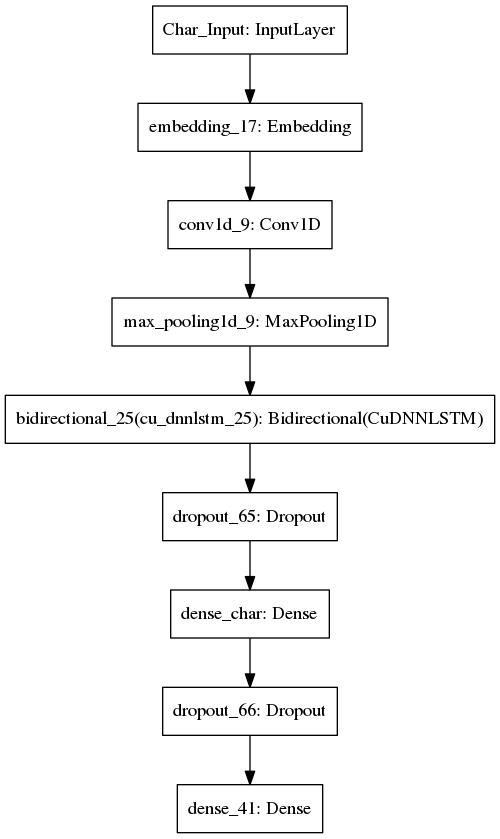

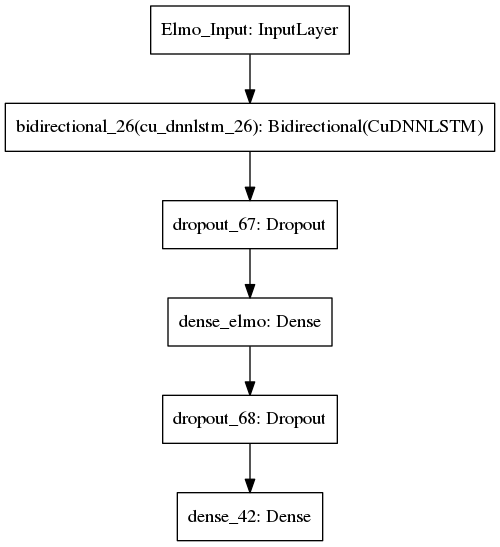

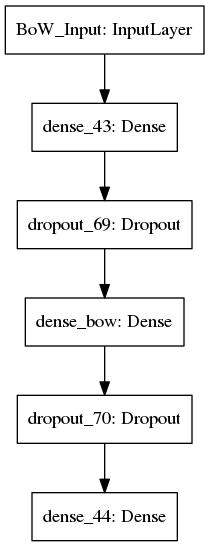

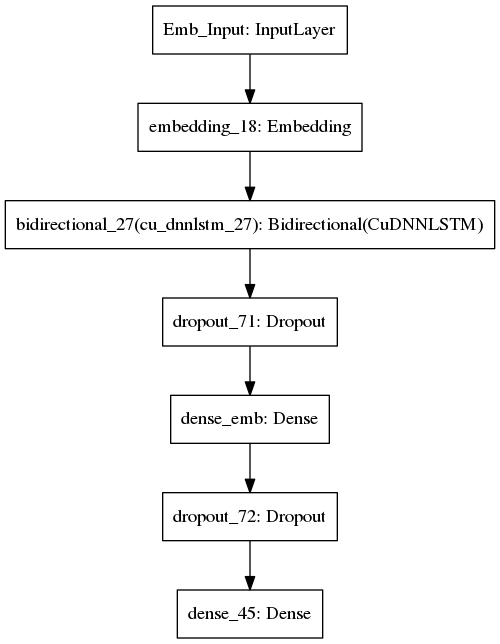

In [43]:
from keras.models import Model
from keras.layers import (
    Dense, GRU, Dropout, LSTM, Bidirectional, Embedding, GlobalAveragePooling1D,
    CuDNNLSTM, CuDNNGRU, Conv1D, MaxPooling1D, Input, Concatenate, BatchNormalization)
from keras.optimizers import Adam
from keras.utils import plot_model
from IPython.display import Image

recursive_class = CuDNNLSTM

def create_char_graph(max_charlen, vocab_size, embedding_dim=64, filters=128, kernel_size=6,
                      pooling_size=3, lstm_units=128, dense_units=128, dropout=[0.75, 0.50]):
    input_char = Input(shape=(max_charlen,), name="Char_Input")
    x = Embedding(vocab_size, embedding_dim)(input_char)
    x = Conv1D(filters=filters, kernel_size=kernel_size, 
               padding='same', activation='relu')(x) 
    
    x = MaxPooling1D(pool_size=pooling_size)(x)
    x = Bidirectional(recursive_class(lstm_units))(x)
    x = Dropout(dropout[0])(x)
    x = Dense(dense_units, activation='relu', name='dense_char')(x)
    x = Dropout(dropout[1])(x)
    output = Dense(1, activation='sigmoid')(x)
    return input_char, output


def create_elmo_graph(max_length, lstm_units=128, dense_units=128, dropout=[0.75, 0.50]):
    input_elmo = Input(shape=(max_length, elmo_dim), name="Elmo_Input")
    y = Bidirectional(recursive_class(lstm_units))(input_elmo)
    y = Dropout(dropout[0])(y)
    y = Dense(dense_units, activation='relu', name='dense_elmo')(y)
    y = Dropout(dropout[1])(y)
    output = Dense(1, activation='sigmoid')(y)
    return input_elmo, output

def create_bow_graph(input_shape, dense_units=512, dropout=[0.75, 0.50]):
    input_bow = Input(shape=input_shape, name="BoW_Input")
    z = Dense(dense_units, activation='relu')(input_bow)
    z = Dropout(dropout[0])(z)
    z = Dense(128, activation='relu', name='dense_bow')(z)
    z = Dropout(dropout[1])(z)
    output = Dense(1, activation='sigmoid')(z)
    return input_bow, output

def create_embeddings_graph(max_len, embedding_matrix, lstm_units=256, dense_units=128, dropout=[0.75, 0.50]):
    input_embeddings = Input(shape=(max_len, ), name="Emb_Input")

    w = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
                  input_length=max_len, weights=[embedding_matrix], trainable=False)(input_embeddings)
    #w = GlobalAveragePooling1D()(w)
    w = Bidirectional(recursive_class(lstm_units))(w)
    w = Dropout(dropout[0])(w)
    w = Dense(dense_units, activation='relu', name='dense_emb')(w)
    w = Dropout(dropout[1])(w)
    output = Dense(1, activation='sigmoid')(w)
    return input_embeddings, output




dropouts = [0.75, 0.55]


input_char, output_char = create_char_graph(
    max_charlen, vocab_size, embedding_dim=64, lstm_units=128, 
    filters=128, kernel_size=6, pooling_size=4,
    dropout=dropouts)

input_elmo, output_elmo = create_elmo_graph(elmo_max_length, lstm_units=96, dropout=dropouts)
input_bow, output_bow = create_bow_graph(input_shape=(X_bow_train.shape[1],), dense_units=128, dropout=dropouts)

input_emb, output_emb = create_embeddings_graph(emb_max_length, embedding_matrix, lstm_units=64, dropout=dropouts)

char_model = Model(inputs=[input_char], outputs=[output_char])
elmo_model = Model(inputs=[input_elmo], outputs=[output_elmo])
bow_model = Model(inputs=[input_bow], outputs=[output_bow])
emb_model = Model(inputs=[input_emb], outputs=[output_emb])


use_char = True
use_elmo = True
use_bow = True
use_emb = True


if use_char:
    pass
if use_elmo:
    pass
if use_bow:
    pass
if use_emb:
    pass

images = []

print(char_model.summary())
plot_model(char_model, to_file='/tmp/char_model.png')
images.append(Image('/tmp/char_model.png'))

print(elmo_model.summary())
plot_model(elmo_model, to_file='/tmp/elmo_model.png')
images.append(Image('/tmp/elmo_model.png'))

print(bow_model.summary())
plot_model(bow_model, to_file='/tmp/bow_model.png')
images.append(Image('/tmp/bow_model.png'))

print(emb_model.summary())
plot_model(emb_model, to_file='/tmp/emb_model.png')
images.append(Image('/tmp/emb_model.png'))

from IPython.display import display

display(*images)

In [46]:
optimizer_args = {
    "lr": 0.001,
    "decay": 0.01,
    "amsgrad": False
}




char_model.compile(loss='binary_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

elmo_model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])

bow_model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])

emb_model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])


In [47]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint('/tmp/char_ensemble_13.h5', save_best_only=True, monitor='val_acc', verbose=1)

char_model.fit(X_char_train, y_train, callbacks=[checkpointer],
          validation_data=(X_char_dev, y_dev), epochs=50, batch_size=32)


Train on 4500 samples, validate on 500 samples
Epoch 1/50
4500/4500 [==============================] - 4s 990us/step - loss: 0.6497 - acc: 0.6616 - val_loss: 0.6624 - val_acc: 0.6440

Epoch 00001: val_acc improved from -inf to 0.64400, saving model to /tmp/char_ensemble_13.h5
Epoch 2/50
4500/4500 [==============================] - 2s 530us/step - loss: 0.5849 - acc: 0.7073 - val_loss: 0.6072 - val_acc: 0.6740

Epoch 00002: val_acc improved from 0.64400 to 0.67400, saving model to /tmp/char_ensemble_13.h5
Epoch 3/50
4500/4500 [==============================] - 2s 536us/step - loss: 0.5540 - acc: 0.7269 - val_loss: 0.6456 - val_acc: 0.6800

Epoch 00003: val_acc improved from 0.67400 to 0.68000, saving model to /tmp/char_ensemble_13.h5
Epoch 4/50
4500/4500 [==============================] - 2s 533us/step - loss: 0.5129 - acc: 0.7496 - val_loss: 0.5524 - val_acc: 0.7380

Epoch 00004: val_acc improved from 0.68000 to 0.73800, saving model to /tmp/char_ensemble_13.h5
Epoch 5/50
4500/4500 [==

In [48]:
from hate.utils import print_evaluation

char_model.load_weights(checkpointer.filepath)


print_evaluation(char_model, X_char_dev, y_dev)

500/500 [==============================] - 0s 199us/step
Loss        : 0.5950
Accuracy    : 0.7620
Precision   : 0.7085
Recall      : 0.7883
F1          : 0.7463


In [49]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint('/tmp/elmo_ensemble_13.h5', save_best_only=True, monitor='val_acc', verbose=1)

elmo_model.fit(X_elmo_train, y_train, callbacks=[checkpointer],
          validation_data=(X_elmo_dev, y_dev), epochs=30, batch_size=32)


Train on 4500 samples, validate on 500 samples
Epoch 1/30
4500/4500 [==============================] - 5s 1ms/step - loss: 0.7173 - acc: 0.5484 - val_loss: 0.6747 - val_acc: 0.5860

Epoch 00001: val_acc improved from -inf to 0.58600, saving model to /tmp/elmo_ensemble_13.h5
Epoch 2/30
4500/4500 [==============================] - 3s 711us/step - loss: 0.6675 - acc: 0.5967 - val_loss: 0.6521 - val_acc: 0.6480

Epoch 00002: val_acc improved from 0.58600 to 0.64800, saving model to /tmp/elmo_ensemble_13.h5
Epoch 3/30
4500/4500 [==============================] - 3s 721us/step - loss: 0.6379 - acc: 0.6418 - val_loss: 0.6283 - val_acc: 0.6740

Epoch 00003: val_acc improved from 0.64800 to 0.67400, saving model to /tmp/elmo_ensemble_13.h5
Epoch 4/30
4500/4500 [==============================] - 3s 720us/step - loss: 0.6202 - acc: 0.6647 - val_loss: 0.6034 - val_acc: 0.6880

Epoch 00004: val_acc improved from 0.67400 to 0.68800, saving model to /tmp/elmo_ensemble_13.h5
Epoch 5/30
4500/4500 [====

In [50]:
from hate.utils import print_evaluation

elmo_model.load_weights(checkpointer.filepath)


print_evaluation(elmo_model, X_elmo_dev, y_dev)

500/500 [==============================] - 0s 355us/step
Loss        : 0.4247
Accuracy    : 0.8180
Precision   : 0.8075
Recall      : 0.7748
F1          : 0.7908


In [51]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint('/tmp/bow_ensemble_13.h5', save_best_only=True, monitor='val_acc', verbose=1)

bow_model.fit(X_bow_train, y_train, callbacks=[checkpointer],
          validation_data=(X_bow_dev, y_dev), epochs=30, batch_size=32)


Train on 4500 samples, validate on 500 samples
Epoch 1/30
4500/4500 [==============================] - 3s 659us/step - loss: 0.6573 - acc: 0.5969 - val_loss: 0.6213 - val_acc: 0.6480

Epoch 00001: val_acc improved from -inf to 0.64800, saving model to /tmp/bow_ensemble_13.h5
Epoch 2/30
4500/4500 [==============================] - 1s 221us/step - loss: 0.5784 - acc: 0.7149 - val_loss: 0.5437 - val_acc: 0.7520

Epoch 00002: val_acc improved from 0.64800 to 0.75200, saving model to /tmp/bow_ensemble_13.h5
Epoch 3/30
4500/4500 [==============================] - 1s 211us/step - loss: 0.5100 - acc: 0.7789 - val_loss: 0.4967 - val_acc: 0.7680

Epoch 00003: val_acc improved from 0.75200 to 0.76800, saving model to /tmp/bow_ensemble_13.h5
Epoch 4/30
4500/4500 [==============================] - 1s 212us/step - loss: 0.4643 - acc: 0.7940 - val_loss: 0.4718 - val_acc: 0.7860

Epoch 00004: val_acc improved from 0.76800 to 0.78600, saving model to /tmp/bow_ensemble_13.h5
Epoch 5/30
4500/4500 [======

In [52]:
from hate.utils import print_evaluation

bow_model.load_weights(checkpointer.filepath)


print_evaluation(bow_model, X_bow_dev, y_dev)

500/500 [==============================] - 0s 99us/step
Loss        : 0.4396
Accuracy    : 0.8140
Precision   : 0.8028
Recall      : 0.7703
F1          : 0.7862


In [78]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint('/tmp/emb_ensemble_13.h5', save_best_only=True, monitor='val_acc', verbose=1)

emb_model.fit(X_emb_train, y_train, callbacks=[checkpointer],
          validation_data=(X_emb_dev, y_dev), epochs=30, batch_size=32)


Train on 4500 samples, validate on 500 samples
Epoch 1/30
4500/4500 [==============================] - 4s 974us/step - loss: 0.6616 - acc: 0.6136 - val_loss: 0.6258 - val_acc: 0.6740

Epoch 00001: val_acc improved from -inf to 0.67400, saving model to /tmp/emb_ensemble_13.h5
Epoch 2/30
4500/4500 [==============================] - 2s 433us/step - loss: 0.5951 - acc: 0.6980 - val_loss: 0.5761 - val_acc: 0.7000

Epoch 00002: val_acc improved from 0.67400 to 0.70000, saving model to /tmp/emb_ensemble_13.h5
Epoch 3/30
4500/4500 [==============================] - 2s 430us/step - loss: 0.5496 - acc: 0.7407 - val_loss: 0.5273 - val_acc: 0.7460

Epoch 00003: val_acc improved from 0.70000 to 0.74600, saving model to /tmp/emb_ensemble_13.h5
Epoch 4/30
4500/4500 [==============================] - 2s 427us/step - loss: 0.5180 - acc: 0.7582 - val_loss: 0.5185 - val_acc: 0.7500

Epoch 00004: val_acc improved from 0.74600 to 0.75000, saving model to /tmp/emb_ensemble_13.h5
Epoch 5/30
4500/4500 [======

In [79]:
from hate.utils import print_evaluation

emb_model.load_weights(checkpointer.filepath)


print_evaluation(emb_model, X_emb_dev, y_dev)

500/500 [==============================] - 0s 166us/step
Loss        : 0.4715
Accuracy    : 0.7980
Precision   : 0.7597
Recall      : 0.7973
F1          : 0.7780


## Ensemble de "promedios"

¿Cuánto da de accuracy si promediamos los valores?

In [103]:
from sklearn.metrics import accuracy_score
y_char_pred = char_model.predict(X_char_dev)
y_elmo_pred = elmo_model.predict(X_elmo_dev)
y_bow_pred = bow_model.predict(X_bow_dev)
y_emb_dev = emb_model.predict(X_emb_dev)



Todos

In [106]:
outputs = np.hstack((y_char_pred, y_elmo_pred, y_bow_pred, y_emb_dev))

y_pred = outputs.mean(axis=1) >= 0.5

accuracy_score(y_dev, y_pred)

0.826

Sin embeddings

In [107]:
outputs = np.hstack((y_char_pred, y_elmo_pred, y_bow_pred))

y_pred = outputs.mean(axis=1) >= 0.5

accuracy_score(y_dev, y_pred)

0.832

Sin Char

In [108]:
outputs = np.hstack((y_elmo_pred, y_bow_pred, y_emb_dev))

y_pred = outputs.mean(axis=1) >= 0.5

accuracy_score(y_dev, y_pred)

0.83

Sin bow

In [110]:
outputs = np.hstack((y_char_pred, y_elmo_pred, y_emb_dev))

y_pred = outputs.mean(axis=1) >= 0.5

accuracy_score(y_dev, y_pred)

0.82

Char + Elmo

In [112]:
outputs = np.hstack((y_char_pred, y_elmo_pred))

y_pred = outputs.mean(axis=1) >= 0.5

accuracy_score(y_dev, y_pred)

0.796

Char + BoW

In [115]:
outputs = np.hstack((y_char_pred, y_bow_pred))

y_pred = outputs.mean(axis=1) >= 0.5

accuracy_score(y_dev, y_pred)

0.8

Char + Emb

In [117]:
outputs = np.hstack((y_char_pred, y_emb_dev))

y_pred = outputs.mean(axis=1) >= 0.5

accuracy_score(y_dev, y_pred)

0.802

Elmo + BoW

In [118]:
outputs = np.hstack((y_elmo_pred, y_bow_pred))

y_pred = outputs.mean(axis=1) >= 0.5

accuracy_score(y_dev, y_pred)

0.834

ElMo + Emb

In [119]:
outputs = np.hstack((y_elmo_pred, y_emb_dev))

y_pred = outputs.mean(axis=1) >= 0.5

accuracy_score(y_dev, y_pred)

0.822

Parece que lo mejor es ELMO + BoW + quizás Char

## Error Analysis

Vamos a ver los tweets con mayores errores

In [123]:
outputs = np.hstack((y_char_pred, y_elmo_pred, y_bow_pred))
df_dev["proba"] = outputs.mean(axis=1)


true_positives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] >= 0.5)].copy()
true_negatives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] < 0.5)].copy()

false_positives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] > 0.5)].copy()
false_positives.sort_values("proba", ascending=False, inplace=True)


false_negatives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] < 0.5)].copy()
false_negatives.sort_values("proba", ascending=True, inplace=True)

conf_matrix = pd.DataFrame([
    {"real":"hs=1", "pred_true": len(true_positives), "pred_false": len(false_negatives)},
    {"real":"hs=0", "pred_true": len(false_positives), "pred_false": len(true_negatives)}
])



conf_matrix.set_index("real", inplace=True)

print("Falsos negativos: {}".format(len(false_negatives)))
print("Falsos positivos: {}".format(len(false_positives)))

conf_matrix[["pred_true", "pred_false"]]

Falsos negativos: 45
Falsos positivos: 39


,pred_true,pred_false
real,,
hs=1,177,45
hs=0,39,239


## Falsos Negativos

Veamos los 20 falsos negativos en los cuales nuestro modelo se equivoca más

In [124]:
pd.set_option('max_colwidth', 300)

false_negatives[["text", "proba"]]


,text,proba
id,,
21072,"Voy andando por la calle y me han dicho cosas en árabe ya que me estas acosando dime lo en español para que te entienda, asique como yo no les entiendo me he cagado en su puta madre en árabe para que ellos a mi si.",0.053848
24352,"¿Ves que tu coño me importe? Cómete mi polla, basura https://t.co/ht02KyYWZh",0.104640
21215,"Que tal otro aporte anónimo son de la puta de mi esposa, así los dejó en navidad enseñando le los calzones al vecino rt y siguenos @TANGASUCIA @Tangasrobadas https://t.co/70ioUjveqY",0.109435
22065,| lo único que dominas es mi polla en tu cara. https://t.co/qlYOd4zPwW,0.160813
23716,"- El otro día me comí a Laura es muy fácil que guarra jajajaja - Laura también te comió a ti entonces tú eres igual de guarro e igual de fácil. - Puto feminazi putas modas eres feminista solo para ligar bien queda gilipollas - em, ok",0.198587
23922,Pobre moromierda. Pues a mi me parece mas digna y respetable la vida de una linda gallina que acabará en un KFC que ése semita culturizado en el país de la violación que acaban de dejar libre https://t.co/lrL1K09aIb,0.216723
20213,"@britneyspears Perra te lo mereces, esa presentación de WORK BICTH estuvo a tu altura, por fin le hiciste justicia a la canción y al álbum Britney Jean al presentar la canción en un programa de TV luciendo hermosa, acuerpada y subliminal",0.217936
24488,Un indocumentado...habla y habla y no para y acaba hablando su ignorancia.Empezamos bien. https://t.co/SMRsqjtEBT,0.221825
24925,"La verdad que si, no veia la hora de llegar a los 5 mil amigos😂 ahora de a poco voy borrando esos indios indocumentados😂 https://t.co/Xw8q4GLM8v",0.228921


¿Cómo los tokenizamos?

In [125]:
df_dev.loc[21841]["text"]

'La otra no noticia del día es la visita del sonriente Casado a Algeciras, a visitar en Ceuta y Algeciras, no a los guardias civiles heridos tras la violenta entrada de ilegales del otro día, sino a un grupo de subsaharianos que han entrado en nuestro país de forma igualmente ileg'

## Falsos positivos

In [126]:
pd.set_option('max_colwidth', 300)
false_positives[["text", "proba"]]

,text,proba
id,,
21892,@saancisco Callate puta tu eres el traidor.,0.971176
24159,"@LeonDeJapon Jajajajajaja tu eres uno, diego jajajajajaja mentira perra perra perrraaaaaaaaaa de mierda jajaja ♡",0.949714
21050,@GvyMC @Wismichu Callate puta rata😂😂 ya estas llorando??,0.908704
22014,Ni tú eres una zorra hambrienta ni yo un incorregible depredador.,0.894342
23565,La solución no es darle papeles a todos. Es exigir a nuestro gobierno q no fabrique y venda armas a los gobiernos subsaharianos para que estos no masacren y acorralen a su población haciendo q quieran venir aquí x lo civil o criminal. Desesperación y supervivencia pura.,0.876209
22115,"Una chica no es una guarra, una zorra, una puta, una buscan por su manera de vestir.",0.870437
22457,"De Colombia tocará emigrar en pateras, como hacen los africanos subsaharianos.",0.866394
24402,zorra eres tu que no te sientes hombre y no entiendes que toda mujer es bella,0.833239
22416,@Pepe_ElEzequiel Puta!? Puta con las que vos te metes Esa mujer es un ángel enviado por Jesucristo nuestro señor para darnos esa paz que buscamos sólo con verla,0.828367


# Conclusiones

No mejora mucho usando embeddings también! mejor quedémonos el otro modelo...